# Electromagnetic data wrangling

*J. C. Runnoe, A. Stemo (2023)*

Some material in this lecture and notebook is based upon the lectures of A. Myers and J. Runnoe's "Data Mining in Large Astronomical Surveys" class at the University of Wyoming and Vanderbilt University.

---

## Contents
* [Reading in data](#one)
* [Cross-matching](#two)
* [Galactic extinction corrections](#three)
* [Calculating luminosity](#four)
* [Calculating mass](#five)
* [Exercises](#six)
    
---

Please pause for a few minutes and install these two packages: `sfdmaps` and `extinction`. You will also need to download the `sfddata` directory which has galactic dust maps in order to complete this lesson.

In [1]:
!pip install sfdmap

In [2]:
!pip install extinction

In [3]:
!git clone https://github.com/kbarbary/sfddata

Cloning into 'sfddata'...
remote: Enumerating objects: 7, done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 7
Receiving objects: 100% (7/7), 92.34 MiB | 17.18 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [4]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
import sfdmap
import extinction
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# I like these options to make my plots pretty
fontfamily = 'Times New Roman'
mpl.rcParams['font.family'] = fontfamily
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
plt.rc('xtick.major',pad=2)
plt.rc('ytick.major',pad=2)
plt.rc('xtick.minor',pad=2)
plt.rc('ytick.minor',pad=2)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('font',size=10,weight='bold')
plt.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['figure.dpi'] = 300

In [6]:
ra_hms  = '23h12m11s'
dec_hms = '-41d12m13s'
c = SkyCoord(ra_hms,dec_hms,unit=(u.hourangle,u.deg))

## Reading in data <a class="anchor" id="one"></a>

Reading and writing data is a fundamental computational task in astronomy, and there are many ways to do it. A generation ago when disk space was not as cheap, astronomers often invented data file formats in order to store their electromagnetic observations (ask me about `3ca` files). Now, while there are a variety of methods, your data will most likely appear in the `ascii` or `fits` formats. Two other formats you can investigate on your own are `npy` files and `pickles`.

Try the cells below to read and write data of various kinds to your computer.

#### Resources
- [astropy](https://www.astropy.org) you should already have this
- [astropy tables](https://docs.astropy.org/en/stable/table/#) documentation
- [numpy.loadtxt](https://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html) documentation
- [numpy.savetxt](https://numpy.org/doc/stable/reference/generated/numpy.savetxt.html) documentation
- [numpy.genfromtxt](https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html) documentation
- [PyFITS -  (astro) industry standard fits file handler](https://docs.astropy.org/en/stable/io/fits/)
- [PyFITS documentation from STScI](http://stsdas.stsci.edu/download/wikidocs/The_PyFITS_Handbook.pdf)
- [Why did astropy adopt PyFITS?](https://docs.astropy.org/en/stable/io/fits/appendix/faq.html#comparison-with-other-fits-readers)
- [More than you ever wanted to know about the FITS standard](https://fits.gsfc.nasa.gov/fits_standard.html)
- [What are rec arrays?](https://jakevdp.github.io/PythonDataScienceHandbook/02.09-structured-data-numpy.html)
- [Pickling](https://docs.python.org/3/library/pickle.html)

In [7]:
import numpy as np
from astropy.io import ascii
from astropy.table import Table
from astropy.io import fits

In [8]:
# make fake data
# save it in an astropy Table
data_write = Table()
data_write['x'] = np.array([5,10,20], dtype=np.int32)
data_write['y'] = data_write['x'] ** 3
data_write

x,y
int32,int32
5,125
10,1000
20,8000


In [9]:
# ASCII
# writing using astropy.io.ascii
ascii.write(data_write, 'ascii_table.dat', overwrite=True)

# reading using astropy.io.ascii
data_read = ascii.read('ascii_table.dat')
data_read

x,y
int64,int64
5,125
10,1000
20,8000


In [10]:
# read using np.genfromtxt
x,y  = np.genfromtxt('ascii_table.dat',unpack=True,usecols=(0,1),skip_header=1)
x,y

(array([ 5., 10., 20.]), array([ 125., 1000., 8000.]))

In [11]:
# write using np.savetxt (gotta be honest, this is a bit cumbersome)
data_to_write = [i for i in zip(x,y)]
np.savetxt('ascii_table_np.dat',data_to_write,fmt='%1.0f',header=' x  y', delimiter=' ',comments='', newline='\n ')

In [12]:
# write using fits
# first you have to package the data in a fits header data unit (HDU)
data_fits = fits.BinTableHDU(data_write) 
data_fits.writeto('fits_table.fits',overwrite=True)

In [13]:
# read in using fits
# you can explore a bit after doing this, which is handy with astronomical data but not that interesting now
hdu = fits.open('fits_table.fits')
hdu.info()

Filename: fits_table.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     12   3R x 2C   [J, J]   


In [14]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  

In [15]:
# your data are here
# they come back in something called a 'rec array'
data_from_fits = hdu[1].data
data_from_fits, data_from_fits['x']

(FITS_rec([( 5,  125), (10, 1000), (20, 8000)],
          dtype=(numpy.record, [('x', '>i4'), ('y', '>i4')])),
 array([ 5, 10, 20], dtype=int32))

## Cross-matching data <a class="anchor" id="two"></a>

Finding the angular distance between two objects on the sky is a very common problem in astronomy. However, finding multiple distances on the sphere can quickly become difficult and computationally expensive. 

Consider an astronomical survey with 1 million galaxies: if you need the distances between all of them, this is $(1$ million$ \times 999999)/2$ distances! Often, you won't care about all $\sim5 \times 10^{11}$ distances, you may only want to measure distances between objects are close on the sky, perhaps within a $1^{\circ}\times1^{\circ}$ field of view. This is where indexing schemes become useful.

#### The problem in a nutshell

**<font color='red'>Find all pairs of points that are separated by <100m</font>.**
![indexing](figs/index1.png)

To do this, first divide your region into four equal pixels and number them 1-4.

![indexing](figs/index2.png)

Then further divide each pixel into four and label them according to their original pixel, plus the new sub-pixel. Each point in a pixel is assigned the pixel name, so the three points in pixel 22 are all labeled 22.

![indexing](figs/index3.png)

As you progress hierarchically down the tree to the next “level”, you quadruple the number of pixels and the label or “index” grows by one integer. Eventually, each point has a unique index (is in its own pixel) and you can stop building the tree. If empty pixels are then discarded, you have exactly as many pixels as points. The pixel size is known at each level, so if only points separated by, e.g., 100m, are needed, then only some subset of points in adjacent pixels need to be considered.

This is called a quad tree. Tree structures are desirable for a number of reasons:
- Recursive bisection is a very rapid algorithm.
- The indexing is simple and easy to store as an integer.
- Because each dimension is always being halved, the area and/or dimensions of each pixel are easy to track. This means that the separation between pixels at each level is easy to calculate.

Several sophisticated tree structures are used for indexing in astronomy, with one goal being to rapidly find adjacent points in a large amount of data.

#### Cross-matching

A useful routine in astropy that uses a tree scheme to rapidly perform distance measurements on the sphere is the `search_around_sky` procedure. `search_around_sky` uses a k-dimensional (or k-d) tree to pixelate the sky. A k-d tree essentially recursively bisects a dataset perpendicular to each coordinate axis (e.g. bisects in Cartesian x, y, z in turn; see the resource link). Bisections occur close to the median data point along a coordinate axis, so that on each split, about half of the data ends up in each “child” pixel.

Coordinate matching is easily my single most-used routine for data manipulation in large surveys. Execute the cells below to practice finding data within some sepration of a point and cross-matching surveys.

#### Resources
- [The k-d tree](https://en.wikipedia.org/wiki/K-d_tree)
- [astropy and 2-D distances on the sphere](http://docs.astropy.org/en/stable/coordinates/#convenience-methods)[astropy and 2-D distances on the sphere]
- [Matching a set of points to another set of points](http://docs.astropy.org/en/stable/coordinates/matchsep.html#searching-around-coordinates)

One common use of separation is to take two sets of object coordinates in arrays [ra1], [dec1] and [ra2], [dec2] and find angular distances between the objects.

In [16]:
ra1, dec1 = [8.,9.,10.,8.]*u.degree,[0.,0.,0.,80.]*u.degree
ra2, dec2 = [18.,19.,21.,18.]*u.degree,[0.,0.,0.,80.]*u.degree
c1 = SkyCoord(ra1, dec1, frame='icrs')
c2 = SkyCoord(ra2, dec2, frame='icrs')
c1.separation(c2)

<Angle [10.        , 10.        , 11.        ,  1.73434482] deg>

The result here is an angle, because because [8.,0.] is separated from [18.,0.] by 10$^{circ}$ and [10.,0.] is separated from [21.,0.] by 11$^{\circ}$ etc. Note that you cannot simply take the difference due to the spherical geometry of the sky.

A second use of separation is to take a single point in the sky and find all objects within some distance of it. This is useful, e.g., if you are following-up a “circular” area on the sky with a spectroscopic plate. Say I’m placing a 1.5$^{\circ}$ radius plate at $\alpha = 20^{\circ}$, $\delta=0^{\circ}$ and I want to know which objects in the sky will fall on it.

In [17]:
ra1, dec1 = [20.]*u.degree,[0.]*u.degree
ra2, dec2 = [18.,19.,21.]*u.degree,[0.,0.,0.]*u.degree
c1 = SkyCoord(ra1, dec1, frame='icrs')
c2 = SkyCoord(ra2, dec2, frame='icrs')
w = np.where(c1.separation(c2) < 1.5*u.degree)
w

(array([1, 2]),)

Here, w is array([1, 2]) because the 1st and 2nd points are within 1.5$^{\circ}$ of $\alpha = 20^{\circ}$, $\delta=0^{\circ}$.

You can also match all of a set of points to all of a second set using SkyCoord’s search_around_sky method:


In [18]:
ra1, dec1 = [8.,9.,10.]*u.degree,[0.,0.,0.]*u.degree
ra2, dec2 = [18.,19.,21.]*u.degree,[0.,0.,0.]*u.degree
c1 = SkyCoord(ra1, dec1, frame='icrs')
c2 = SkyCoord(ra2, dec2, frame='icrs')
id1, id2, d2, d3 = c2.search_around_sky(c1, 9.1*u.deg)
id1,id2

(array([1, 2, 2]), array([0, 0, 1]))

The result is id1 = [1, 2, 2] and id2 = [0, 0, 1] because [9.,0.] is separated from [18.,0.] by < 9.1$^{\circ}$ and [10.,0.] is separated from [18.,0.] by < 9.1$^{\circ}$ and [10.,0.] is separated from [19.,0.] by < 9.1$^{\circ}$.

## Galactic extinction corrections <a class="anchor" id="three"></a>

Robert Trumpler first  confirmed the existence  of interstellar dust ([1930](http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1930LicOB..14..154T&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf);  see resource link and, in  particular, point 5 of the  Summary on page 187) when he noticed that  open star clusters of the  same general apparent size had different brightnesses. Either the real size of clusters increases farther from the Earth (i.e. the Earth is in a special location), or stars become progressively fainter at larger distances. Absorption by interstellar dust would make stars progressively fainter with distance from the Earth.

At the time of writing this lecture, the third most  cited journal paper ([Schlegel et al. 1998](http://adsabs.harvard.edu/abs/1998ApJ...500..525S)) in  astronomy dealt with  the careful mapping  of interstellar dust. The reason it is so highly cited is that any measurement of the flux (or magnitude) from extragalactic sources must corrected for foreground absorption by dust in our Galaxy.

To correct a magnitude for dust, subtract the extinction ($A$) in that band: 

$m_{true} = m_{observed} - A$

The extinction is obtained by using a dust map to tell you the amount of extinction along the line of sight to the $\alpha,\delta$ position of your extragalactic target. The dust maps typically return the color excess $E(B-V) = (B-V)-(B-V)_{0}$, a measure of the amount of reddening along the line of sight. This can be converted to the extinction in the visible band:

$A_{V} = R_{V} \times E(B-V)$, where $R_{V}=3.1$ in the Milky Way.

Note that magnitudes must always be corrected for extinction in the correct band. Dust extinction is wavelength dependent, so you will need an extinction law to translate from $V$ to any other band. This is done with an extinction correction. There are a variety of laws, which differ depending on the composition of the dust and may be relevant in different science applications. 

![extinction law](https://extinction.readthedocs.io/en/latest/index-1.png)

For Milky Way extinction corrections, we will use the Fitzpatrick et al. (1999) law.

#### Resources
- [Github page for sfdmap package](https://github.com/kbarbary/sfdmap)
- [Github page for SFD dust maps in fits format](https://github.com/kbarbary/sfddata)
- [Github page for extinction package](https://github.com/kbarbary/extinction)
- [Dust Maps; Schlegel, Finkbeiner & Davis (1998) -- webpage](http://irsa.ipac.caltech.edu/applications/DUST/docs/background.html)
- [Equations for interstellar reddening](http://astronomy.swin.edu.au/cosmos/I/Interstellar+Reddening)

In [20]:
# JCR set up some coordinates
ra, dec = '00h42m30s', '+41d12m00s'
c       = SkyCoord(ra, dec).galactic

# JCR obtain the reddening at this position in the dust maps 
import sfdmap
dustdir = './sfddata/' # edit this to point to the sfddata/ directory on YOUR computer
m = sfdmap.SFDMap(dustdir, scaling=1)
ebv = m.ebv(c.l.value,c.b.value, frame='galactic')

# JCR or you can do it without converting to Galactic coordinates
ra, dec = '00h42m30s', '+41d12m00s'
c = SkyCoord(ra, dec)
ebv = m.ebv(c.ra.value,c.dec.value)

Finding extinction requires wavelengths and a dust-law from the extinction package. Install the extinction package: 

To find rough extinctions for the SDSS ugriz filters:

In [21]:
wave = np.array([3543., 4770., 6231, 7625., 9134.]) # rough wavelength of SDSS filter centers
A = extinction.fitzpatrick99(wave, 3.1*ebv)

In [23]:
# JCR get Galactic reddening without converting to galactic coords
dustdir = './sfddata/'
m       = sfdmap.SFDMap(dustdir, scaling=1)
ebv     = m.ebv(c.galactic.l.value,c.galactic.b.value, frame='galactic')
print('E(B-V) =',ebv)

E(B-V) = 0.37976796803523627


In [24]:
# alculate the extinction
wave = np.array([3543., 4770., 6231, 7625., 9134.]) # ugriz central wavelengths
A    = extinction.fitzpatrick99(wave, 3.1*ebv)

In [25]:
# JCR plot two quasars and compare their colors
#     these are the ugriz magnitudes for quasars 1 and 2
q1 = [18.82, 18.81, 18.74, 18.81, 18.89]
q2 = [19.37, 19.10, 18.79, 18.72, 18.62]

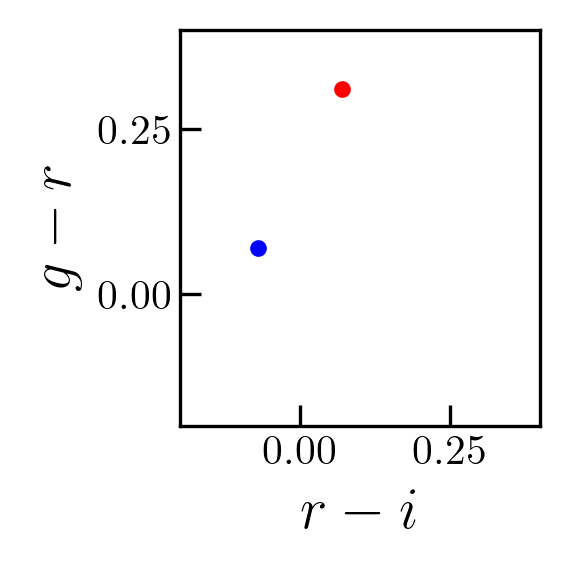

In [26]:
# JCR visualize them
fig, ax = plt.subplots(1, 1, figsize=(2,2))
ax.plot(q1[2]-q1[3],q1[1]-q1[2],'.b',markersize=6)
ax.plot(q2[2]-q2[3],q2[1]-q2[2],'.r',markersize=6)
ax.set_xlabel(r'$r-i$',fontsize=14)
ax.set_ylabel(r'$g-r$',fontsize=14)
ax.set_ylim([-0.2,0.4])
ax.set_xlim([-0.2,0.4])
ax.tick_params(axis ='both', direction = 'in',size=5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [27]:
# JCR sky positions for quasars 1 and 2
c1 = SkyCoord(246.933*u.deg,40.795*u.deg) 
c2 = SkyCoord(236.562*u.deg,2.440*u.deg) 

# JCR load the dust map
#     and get reddening at the quasar positions
m       = sfdmap.SFDMap(dustdir, scaling=1)
ebv1 = m.ebv(c1.ra.value,c1.dec.value) 
ebv2 = m.ebv(c2.ra.value,c2.dec.value) 

# JCR convert from V to ugriz using the Fitzpatrick+99 extinction law
A1    = extinction.fitzpatrick99(wave, 3.1*ebv1)
A2    = extinction.fitzpatrick99(wave, 3.1*ebv2)

# JCR correct quasar 1 and 2 mags for Galactic reddening
q1_true = q1-A1
q2_true = q2-A2

# JCR calculate observed colors
gr1 = q1[1]-q1[2]
gr2 = q2[1]-q2[2]
ri1 = q1[3]-q1[2]
ri2 = q2[3]-q2[2]

# JCR calculate intrinsic colors
gr1_true = q1_true[1]-q1_true[2]
gr2_true = q2_true[1]-q2_true[2]
ri1_true = q1_true[3]-q1_true[2]
ri2_true = q2_true[3]-q2_true[2]

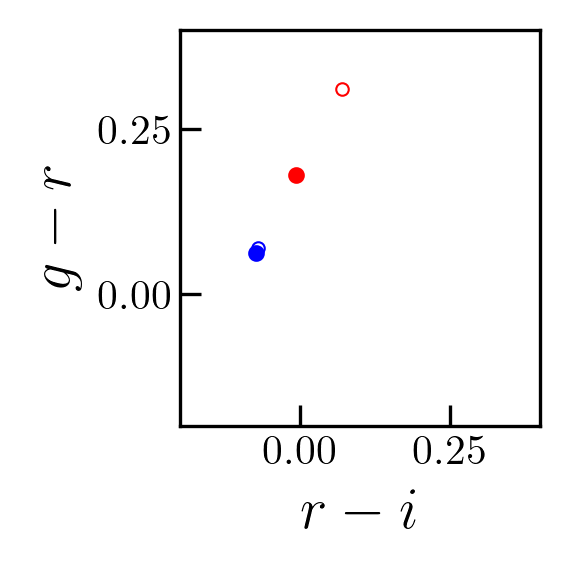

In [28]:
# JCR plot the observed colors and the intrinsic ones
#     to see how different they are
fig, ax = plt.subplots(1, 1, figsize=(2,2))
ax.plot(q1[2]-q1[3],q1[1]-q1[2],'.b',markersize=6,markerfacecolor='white',markeredgewidth=0.5,markeredgecolor='blue')
ax.plot(q2[2]-q2[3],q2[1]-q2[2],'.r',markersize=6,markerfacecolor='white',markeredgewidth=0.5,markeredgecolor='red')
ax.plot(q1_true[2]-q1_true[3],q1_true[1]-q1_true[2],'.b',markersize=6)
ax.plot(q2_true[2]-q2_true[3],q2_true[1]-q2_true[2],'.r',markersize=6)
ax.set_xlabel(r'$r-i$',fontsize=14)
ax.set_ylabel(r'$g-r$',fontsize=14)
ax.set_ylim([-0.2,0.4])
ax.set_xlim([-0.2,0.4])
ax.tick_params(axis ='both', direction = 'in',size=5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Calculating luminosity <a class="anchor" id="four"></a>

Now that we have covered correcting for extinction, we can calculate the absolute magnitude. This is a measure of what the apparent magnitude of an object would be if it was at a distance of 10 parsecs. In this way, absolute magnitude acts to standardize the brightness of objects, and get's us most of the way to estimating luminosity. Below is the equation for absolute magnitude ($M$), as a function of apparent magnitude ($m$), luminosity distance ($D_L$), and a rather tricky parameter called the K correction ($K_{Corr}$).

$M=(m-K_{Corr})-5\;log_{10}\frac{D_{L}}{10pc}$

We will ignore the concept of K corrections here as they are a little tricky to understand -- in short, they correct for the differing shape of a source's SED as it is redshifted across different photometric bands. They are unique for both the objects you are examining, as well as the specific photometric band you are observing them through, in addition to the redshift range at which you are observing them. Note how the K correction can be thought of as a correction to the apparent magnitude, similar to the extinction seen above.

#### Working with Catalog data

We will use magnitude data from observations by the Wide Field Infrared Explorer (WISE) to calculate absolute magnitudes and luminosities. For the rest of this tutorial, we will be using a catalog that we have modified from a real source catalog, called GLADE+. It includes RA, dec, redshift, redshift error, and flux data for the B, J, K, W1, and W2 bands, as well as their associated errors, in units of magnitude. In this catalog, the WISE band magnitudes have already been corrected for extinction.

First we will import this data and examine it.

In [29]:
import numpy as np
import pandas as pd
glade = pd.read_csv('glade_cat.csv',delimiter=',')
glade

,RA,Dec,B,B Error,J,J Error,H,H Error,K,K Error,W1,W1 Error,W2,W2 Error,z_helio,z Error
0,192.721451,41.120152,8.80,NaN,6.084,0.015,5.418,0.015,5.169,0.015,5.611000,NaN,6.120000,NaN,0.000991,0.000029
1,190.904000,1.150290,18.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.409000,NaN,16.940000,NaN,0.002747,0.000549
2,161.956665,12.581630,10.15,NaN,7.268,0.015,6.587,0.015,6.362,0.016,7.513000,NaN,7.868000,NaN,0.002567,0.000074
3,184.877426,14.877717,12.32,NaN,9.344,0.009,8.648,0.011,8.417,0.016,8.902000,NaN,8.934000,NaN,0.003590,0.000104
4,27.673841,21.759899,12.00,NaN,9.982,0.020,9.285,0.022,9.066,0.038,10.822000,NaN,10.909000,NaN,0.008082,0.000234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231814,359.874917,5.574292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.135933,NaN,15.494808,NaN,0.614571,0.053281
231815,359.901014,-2.290648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.235331,NaN,16.784473,NaN,3.310000,0.142230
231816,359.932644,7.447719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.224639,NaN,14.211996,NaN,2.213000,0.106029
231817,359.960559,-1.579748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.663143,NaN,15.824214,NaN,1.773184,0.091515


As we can infer from the headers, this catalog includes sky position, magnitudes in the B, J, H, K, W1, and W2, as well as an estimate of redshift. We will be using the W1 band from WISE here; it is centered in the infrared, near 3.7 microns.

Now that the data has been loaded in, we can begin to manipulate it to get absolute magnitudes. The only things we will need here are the luminosity distance, as estimated by astropy using the given redshifts, and the $K_{Corr}$ for the W1 band, which we take from [Kettlety et al. 2018](https://arxiv.org/abs/1709.08316); it is: 

$K_{Corr,W1}=-7.1\;log_{10}(1+z)$.

In [30]:
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u

def Dl(z):
    dist = cosmo.luminosity_distance(z)      #[Mpc]
    dist = dist * 3.086e24/u.Mpc             #[cm]
    return dist
    
def KcorrW1(z):
    Kcorr = -7.1*np.log10(1+z)
    return Kcorr

def AbsMag(m,z):
    abs_mag = (m-KcorrW1(z))-5*np.log10(Dl(z)/3.086e19)
    return abs_mag

In [31]:
glade["W1 Abs"] = AbsMag(glade["W1"],glade["z_helio"])
glade

/Users/stemoam/opt/anaconda3/envs/emit_school/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


,RA,Dec,B,B Error,J,J Error,H,H Error,K,K Error,W1,W1 Error,W2,W2 Error,z_helio,z Error,W1 Abs
0,192.721451,41.120152,8.80,NaN,6.084,0.015,5.418,0.015,5.169,0.015,5.611000,NaN,6.120000,NaN,0.000991,0.000029,-22.599465
1,190.904000,1.150290,18.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.409000,NaN,16.940000,NaN,0.002747,0.000549,-14.014182
2,161.956665,12.581630,10.15,NaN,7.268,0.015,6.587,0.015,6.362,0.016,7.513000,NaN,7.868000,NaN,0.002567,0.000074,-22.762613
3,184.877426,14.877717,12.32,NaN,9.344,0.009,8.648,0.011,8.417,0.016,8.902000,NaN,8.934000,NaN,0.003590,0.000104,-22.100544
4,27.673841,21.759899,12.00,NaN,9.982,0.020,9.285,0.022,9.066,0.038,10.822000,NaN,10.909000,NaN,0.008082,0.000234,-21.936495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231814,359.874917,5.574292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.135933,NaN,15.494808,NaN,0.614571,0.053281,-25.252992
231815,359.901014,-2.290648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.235331,NaN,16.784473,NaN,3.310000,0.142230,-25.591768
231816,359.932644,7.447719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.224639,NaN,14.211996,NaN,2.213000,0.106029,-27.454304
231817,359.960559,-1.579748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.663143,NaN,15.824214,NaN,1.773184,0.091515,-25.882460


After getting absolute magnitude, we can further calculate what the luminosity would be using a little knowledge of a sphere's surface area, as well specific information related to the transmission curve of the band. The first of these hopefully we all remember as $4\pi r^2$, while the second can be found in the rather prodigeous SVO database found at http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse.

For the W1 WISE band, its zeropoint is $Z_p = 8.1787\times 10^{-12}$ erg/s/cm$^{-2}$/Ang, and its effective wavelength is $\lambda_{Eff}=3.3526\times10^4$ Ang.

Recall that we can relate magnitudes and zeropoints as: $m-m_0 = -2.5\;log_{10}(f/f_0)$

Therefore, we can sub in our zeropoint (note: $m_0 = 0$), and get flux in the same units of our zeropoint: $f=Z_p\;10^{-0.4m}$

The last steps are to multiply by our effective wavelength -- thus avoiding integrating over the band thanks to knowledge of shape of the band's transmission curve, and to multiple by the surface area of the sphere that the object has dispersed its light into. Thus, luminosity can be calculated as:

$L=Z_p\;10^{-0.4(m-K_{Corr})}4\pi D_L^2 \lambda_{Eff}$

Let's create a function to that effect below so that we can plug any W1 magnitude we want into it, and get luminosity out in terms of solar units. Then lets see if we can create a new column in our table for luminosity in the W1 band.

In [2]:
def W1_Lum(m,z):
    W1_Zp = 9.59502e-11                                                       #W1 AB zeropoint [erg/s/cm2/ang]
    W1_lambda_eff = 3.3526e4                                                  #W1 effective wavelength [angstrom]
    Lsol = 3.846e33                                                           #Solar luminosity [erg/s]
    L = W1_Zp * 10**(-0.4*(m-KcorrW1(z))) * 4*np.pi*Dl(z)**2 * W1_lambda_eff  #Luminosity [erg/s]
    L = L/Lsol                                                                #Luminosity [Solar luminosities]
    return L

In [33]:
glade["W1 Lum"] = W1_Lum(glade["W1"],glade["z_helio"])
glade

,RA,Dec,B,B Error,J,J Error,H,H Error,K,K Error,W1,W1 Error,W2,W2 Error,z_helio,z Error,W1 Abs,W1 Lum
0,192.721451,41.120152,8.80,NaN,6.084,0.015,5.418,0.015,5.169,0.015,5.611000,NaN,6.120000,NaN,0.000991,0.000029,-22.599465,9.350710e+08
1,190.904000,1.150290,18.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.409000,NaN,16.940000,NaN,0.002747,0.000549,-14.014182,3.441369e+05
2,161.956665,12.581630,10.15,NaN,7.268,0.015,6.587,0.015,6.362,0.016,7.513000,NaN,7.868000,NaN,0.002567,0.000074,-22.762613,1.086685e+09
3,184.877426,14.877717,12.32,NaN,9.344,0.009,8.648,0.011,8.417,0.016,8.902000,NaN,8.934000,NaN,0.003590,0.000104,-22.100544,5.905761e+08
4,27.673841,21.759899,12.00,NaN,9.982,0.020,9.285,0.022,9.066,0.038,10.822000,NaN,10.909000,NaN,0.008082,0.000234,-21.936495,5.077576e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231814,359.874917,5.574292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.135933,NaN,15.494808,NaN,0.614571,0.053281,-25.252992,1.077098e+10
231815,359.901014,-2.290648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.235331,NaN,16.784473,NaN,3.310000,0.142230,-25.591768,1.471518e+10
231816,359.932644,7.447719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.224639,NaN,14.211996,NaN,2.213000,0.106029,-27.454304,8.180501e+10
231817,359.960559,-1.579748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.663143,NaN,15.824214,NaN,1.773184,0.091515,-25.882460,1.923280e+10


## Calculating mass <a class="anchor" id="five"></a>

Last, we will calculate the stellar mass of the host galaxy. As we discussed in the electromagnetic observables lecture, stellar mass is a very difficult parameter to estimate -- in addition to being a little fuzzy. This is made clear by the number of stellar mass estimates that exist in the literature: you can always tell something isn't fully nailed down by the breadth of estimates that exist -- well known things in science typically have O(1) definitions.

Many of these estimates are based on relating the stellar mass and stellar light -- usually examining a mass to light ratio. Further, in almost all cases, there is an inherit assumption about the total stellar population based on incomplete data, such as one to a few photometric bands. 

For conciseness and clarity, I will only discuss the stellar mass estimate we will use in this summer school, which relies on the W1 magnitude, and is also from [Kettlety et al. 2018](https://arxiv.org/abs/1709.08316). Kettlety finds that there exists a stellar to mass ratio of:

$M_*[M_\odot]\;/\;L_{W1}[L_\odot] = 0.65 \pm 0.07$

for passive galaxies; while for active galaxies, they find a relation of:

$log_{10} \; (M_*[M_\odot]\;/\;L_{W1}[L_\odot]) = -0.4 \pm 0.2$

For simplicity let's just assume that all of our galaxies are passive for now. BUT note that this is not true and another metric should be added to decide if the galaxy is star-forming or quiescent (e.g., $W2-W3 \leq 1.5$ indicates star-forming).

In [34]:
glade["Stellar Mass (Quiescent)"] = 0.65*glade["W1 Lum"]
glade

,RA,Dec,B,B Error,J,J Error,H,H Error,K,K Error,W1,W1 Error,W2,W2 Error,z_helio,z Error,W1 Abs,W1 Lum,Stellar Mass (Quiescent)
0,192.721451,41.120152,8.80,NaN,6.084,0.015,5.418,0.015,5.169,0.015,5.611000,NaN,6.120000,NaN,0.000991,0.000029,-22.599465,9.350710e+08,6.077961e+08
1,190.904000,1.150290,18.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.409000,NaN,16.940000,NaN,0.002747,0.000549,-14.014182,3.441369e+05,2.236890e+05
2,161.956665,12.581630,10.15,NaN,7.268,0.015,6.587,0.015,6.362,0.016,7.513000,NaN,7.868000,NaN,0.002567,0.000074,-22.762613,1.086685e+09,7.063451e+08
3,184.877426,14.877717,12.32,NaN,9.344,0.009,8.648,0.011,8.417,0.016,8.902000,NaN,8.934000,NaN,0.003590,0.000104,-22.100544,5.905761e+08,3.838745e+08
4,27.673841,21.759899,12.00,NaN,9.982,0.020,9.285,0.022,9.066,0.038,10.822000,NaN,10.909000,NaN,0.008082,0.000234,-21.936495,5.077576e+08,3.300425e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231814,359.874917,5.574292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.135933,NaN,15.494808,NaN,0.614571,0.053281,-25.252992,1.077098e+10,7.001139e+09
231815,359.901014,-2.290648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.235331,NaN,16.784473,NaN,3.310000,0.142230,-25.591768,1.471518e+10,9.564869e+09
231816,359.932644,7.447719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.224639,NaN,14.211996,NaN,2.213000,0.106029,-27.454304,8.180501e+10,5.317326e+10
231817,359.960559,-1.579748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.663143,NaN,15.824214,NaN,1.773184,0.091515,-25.882460,1.923280e+10,1.250132e+10


We can also make estimate the stellar mass if we assumed all of our galaxies were star-forming.

In [1]:
glade["Stellar Mass (Star-Forming)"] = 10**(-0.4)+glade["W1 Lum"]
glade

NameError: name 'glade' is not defined